In [47]:
import torch
from torch import nn
import torchmetrics

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt

from helper_functions import plot_decision_boundary, plot_predictions

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# 1 task
Make a binary classification dataset with Scikit-Learn's make_moons() function.
* For consistency, the dataset should have 1000 samples and a random_state=42.
* Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.

In [17]:
X, y = make_moons(n_samples=1000,
                  random_state=42)

print('Example: features - {} || label = {}'.format(X[0], y[0]))
print('Shape of X - {} and shape of y - {}'.format(X.shape, y.shape))

Example: features - [0.00872719 0.36817352] || label = 1
Shape of X - (1000, 2) and shape of y - (1000,)


In [18]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('The number of samples in X_train - {} and in X_test - {}'.format(len(X_train), len(X_test)))

The number of samples in X_train - 800 and in X_test - 200


Text(0.5, 1.0, 'Test')

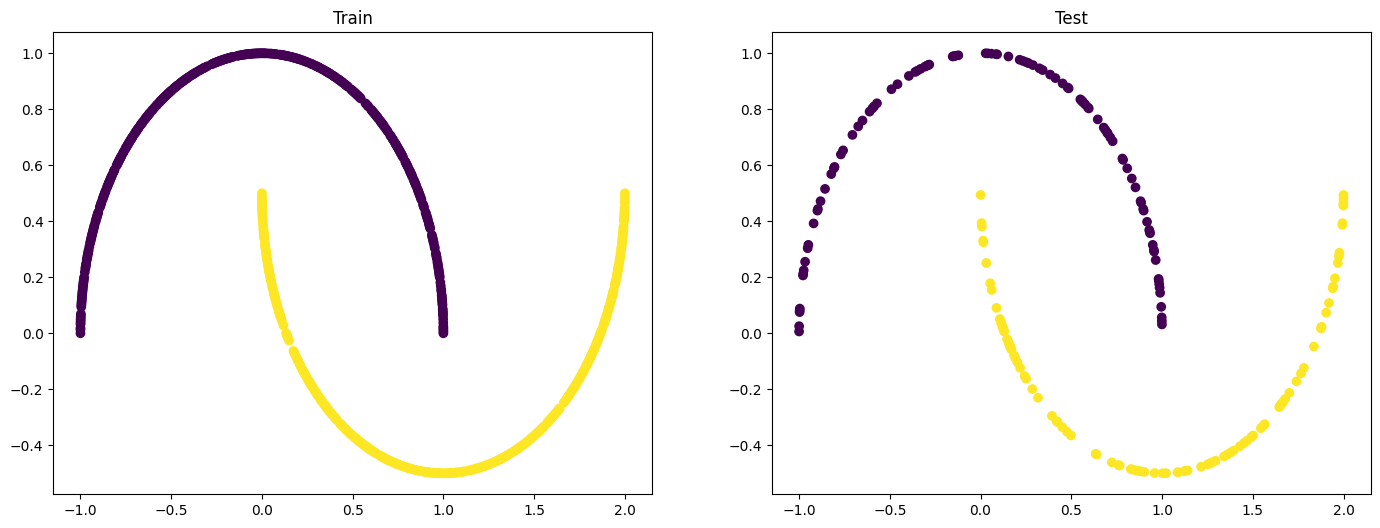

In [19]:
plt.figure(figsize=(17, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.title('Train')

plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.title('Test')

# 2 task
Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
* Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [42]:
class MoonModel(nn.Module):
    def __init__(self, in_fs=2, out_fs=1, hidden_neurons=15):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(in_features=in_fs,
                      out_features=5),
            nn.Softplus(beta=1)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(in_features=5,
                      out_features=10),
            nn.Softplus(beta=2)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(in_features=10,
                      out_features=hidden_neurons),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Linear(in_features=hidden_neurons,
                      out_features=10),
            nn.Softplus(beta=2)
        )
        self.layer5 = nn.Sequential(
            nn.Linear(in_features=10,
                      out_features=5),
            nn.Softplus(beta=1)
        )
        self.layer6 = nn.Linear(in_features=5,
                                out_features=out_fs)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return self.layer6(x)

In [43]:
model_v1 = MoonModel().to(device)
model_v1

MoonModel(
  (layer1): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Softplus(beta=1, threshold=20)
  )
  (layer2): Sequential(
    (0): Linear(in_features=5, out_features=10, bias=True)
    (1): Softplus(beta=2, threshold=20)
  )
  (layer3): Sequential(
    (0): Linear(in_features=10, out_features=15, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softplus(beta=2, threshold=20)
  )
  (layer5): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softplus(beta=1, threshold=20)
  )
  (layer6): Linear(in_features=5, out_features=1, bias=True)
)

# 3 task
Setup a binary classification compatible loss function and optimizer to use when training the model.

In [44]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_v1.parameters(),
                            lr=0.01)

# 4 task
Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
* To measure model accuracy, you can create your own accuracy function or use the accuracy function in TorchMetrics.
* Train the model for long enough for it to reach over 96% accuracy.
* The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [45]:
epochs = 300
acc = torchmetrics.Accuracy()
loss_train_array, loss_test_array, accuracy_array = [], [], []

for epoch in range(1, epochs+1):
    model_v1.train()
    train_logits = model_v1(X_train).squeeze()
    loss_train = loss_fn(train_logits, y_train)
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    model_v1.eval()
    with torch.inference_mode():
        test_logits = model_v1(X_test).squeeze()
        test_labels = torch.round(torch.sigmoid(test_logits)).type(torch.int)
        loss_test = loss_fn(test_logits, y_test)
        accuracy = acc(y_test, test_labels)

    loss_train_array.append(loss_train.item())
    loss_test_array.append(loss_test.item())
    accuracy_array.append(accuracy)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{epochs}:')
        print(f'loss: train = {loss_train.item():.5f}, test = {loss_test.item():.5f}')
        print(f'accuracy on test = {(accuracy*100):.3f}')

Epoch 10/300:
loss: train = 0.68649, test = 0.68519
accuracy on test = 76.000
Epoch 20/300:
loss: train = 0.61438, test = 0.60425
accuracy on test = 77.000
Epoch 30/300:
loss: train = 0.37007, test = 0.40839
accuracy on test = 75.000
Epoch 40/300:
loss: train = 0.31673, test = 0.33085
accuracy on test = 79.500
Epoch 50/300:
loss: train = 0.25921, test = 0.25931
accuracy on test = 89.500
Epoch 60/300:
loss: train = 0.24178, test = 0.24038
accuracy on test = 89.000
Epoch 70/300:
loss: train = 0.23099, test = 0.23834
accuracy on test = 89.000
Epoch 80/300:
loss: train = 0.22427, test = 0.23350
accuracy on test = 89.000
Epoch 90/300:
loss: train = 0.21996, test = 0.23297
accuracy on test = 88.500
Epoch 100/300:
loss: train = 0.21661, test = 0.23405
accuracy on test = 88.000
Epoch 110/300:
loss: train = 0.21344, test = 0.23537
accuracy on test = 87.000
Epoch 120/300:
loss: train = 0.20980, test = 0.23415
accuracy on test = 86.500
Epoch 130/300:
loss: train = 0.20643, test = 0.23208
accuracy

Text(0.5, 0, 'Epoch')

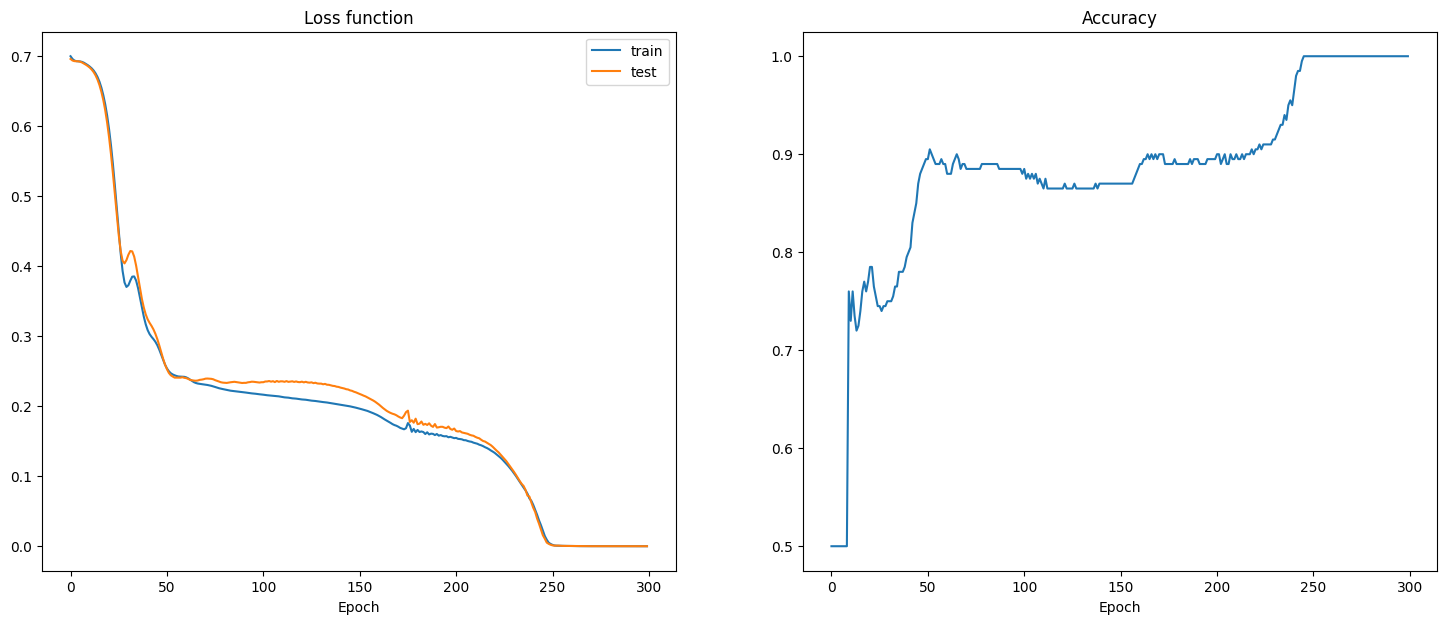

In [46]:
plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
plt.title('Loss function')
plt.plot(loss_train_array, label='train')
plt.plot(loss_test_array, label='test')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(accuracy_array)
plt.xlabel('Epoch')

# 5 task
Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

In [51]:
model_v1.eval()
with torch.inference_mode():
    pred_logits = model_v1(X_test).squeeze()
    pred_labels = torch.round(torch.sigmoid(pred_logits)).type(torch.int)

acc(y_test, pred_labels)

tensor(1.)

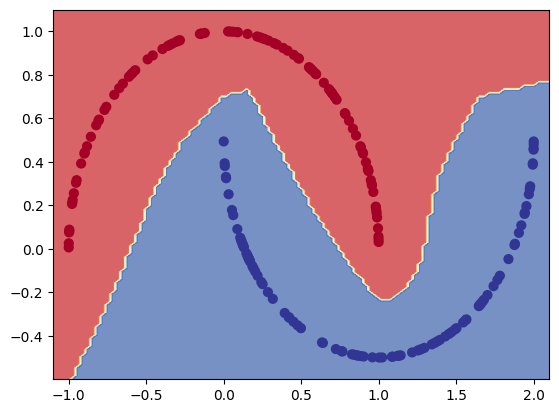

In [52]:
plot_decision_boundary(model=model_v1,
                       X=X_test,
                       y=y_test)

# 6 task
Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
Feel free to reference the ML cheatsheet website for the formula.

Text(0.5, 1.0, 'Tanh activation function')

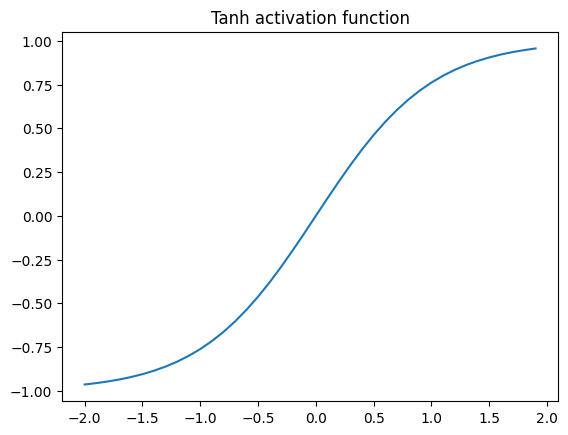

In [57]:
def tanh(z):
    return (torch.exp(z) - torch.exp(-1*z)) / (torch.exp(z) + torch.exp(-1*z))

xax = torch.arange(-2, 2, 0.1)
plt.plot(xax, tanh(xax))
plt.title('Tanh activation function')

# 7 task
Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).
* Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
* Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
* Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
* Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.

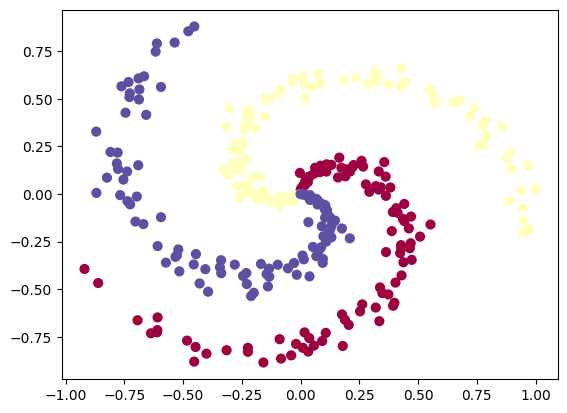

In [73]:
# Code for creating a spiral dataset from CS231n

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [74]:
print('distribution for classes')
unique, counts = np.unique(y, return_counts=True)
print(np.asarray((unique, counts)).T)

distribution for classes
[[  0 100]
 [  1 100]
 [  2 100]]


In [75]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

print('Example: features - {} || label = {}'.format(X[0], y[0]))
print('Shape of X - {} and shape of y - {}'.format(X.shape, y.shape))

Example: features - tensor([-0., 0.]) || label = 0
Shape of X - torch.Size([300, 2]) and shape of y - torch.Size([300])


In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('The number of samples in X_train - {} and in X_test - {}'.format(len(X_train), len(X_test)))

The number of samples in X_train - 240 and in X_test - 60


In [95]:
class SpiralModel(nn.Module):
    def __init__(self, in_fs=2, out_fs=3):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(in_features=in_fs,
                      out_features=5),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(in_features=5,
                      out_features=10),
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.Linear(in_features=10,
                      out_features=20),
            nn.Softplus()
        )
        self.layer4 = nn.Sequential(
            nn.Linear(in_features=20,
                      out_features=10),
            nn.ReLU()
        )
        self.layer5 = nn.Sequential(
            nn.Linear(in_features=10,
                      out_features=5),
            nn.ReLU()
        )
        self.layer6 = nn.Linear(in_features=5,
                                out_features=out_fs)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return self.layer6(x)

In [96]:
model_v2 = SpiralModel().to(device)
model_v2

SpiralModel(
  (layer1): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=5, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
  )
  (layer4): Sequential(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer5): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): ReLU()
  )
  (layer6): Linear(in_features=5, out_features=3, bias=True)
)

In [98]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_v2.parameters(),
                             lr=0.001)
f1_score = torchmetrics.F1Score(num_classes=len(torch.unique(y)))

In [99]:
epochs = 700
loss_train_array, loss_test_array, f1_array = [], [], []

for epoch in range(1, epochs+1):
    model_v2.train()
    train_logits = model_v2(X_train)
    loss_train = loss_fn(train_logits, y_train)
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    model_v2.eval()
    with torch.inference_mode():
        test_logits = model_v2(X_test)
        test_labels = torch.softmax(test_logits, dim=1).argmax(dim=1)
        loss_test = loss_fn(test_logits, y_test)
        f1 = f1_score(y_test, test_labels)

    loss_train_array.append(loss_train.item())
    loss_test_array.append(loss_test.item())
    f1_array.append(f1)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{epochs}:')
        print(f'loss: train = {loss_train.item():.5f}, test = {loss_test.item():.5f}')
        print(f'F1 on test = {f1:.5f}')

Epoch 10/700:
loss: train = 1.11772, test = 1.09404
F1 on test = 0.36667
Epoch 20/700:
loss: train = 1.10190, test = 1.09175
F1 on test = 0.36667
Epoch 30/700:
loss: train = 1.09521, test = 1.09615
F1 on test = 0.45000
Epoch 40/700:
loss: train = 1.09241, test = 1.09888
F1 on test = 0.26667
Epoch 50/700:
loss: train = 1.08953, test = 1.09755
F1 on test = 0.26667
Epoch 60/700:
loss: train = 1.08531, test = 1.09213
F1 on test = 0.31667
Epoch 70/700:
loss: train = 1.07962, test = 1.08468
F1 on test = 0.43333
Epoch 80/700:
loss: train = 1.07143, test = 1.07513
F1 on test = 0.43333
Epoch 90/700:
loss: train = 1.05730, test = 1.05759
F1 on test = 0.50000
Epoch 100/700:
loss: train = 1.03826, test = 1.03808
F1 on test = 0.50000
Epoch 110/700:
loss: train = 1.01553, test = 1.01886
F1 on test = 0.50000
Epoch 120/700:
loss: train = 0.99130, test = 0.99662
F1 on test = 0.50000
Epoch 130/700:
loss: train = 0.96814, test = 0.97679
F1 on test = 0.50000
Epoch 140/700:
loss: train = 0.94598, test = 0.

Text(0.5, 0, 'Epoch')

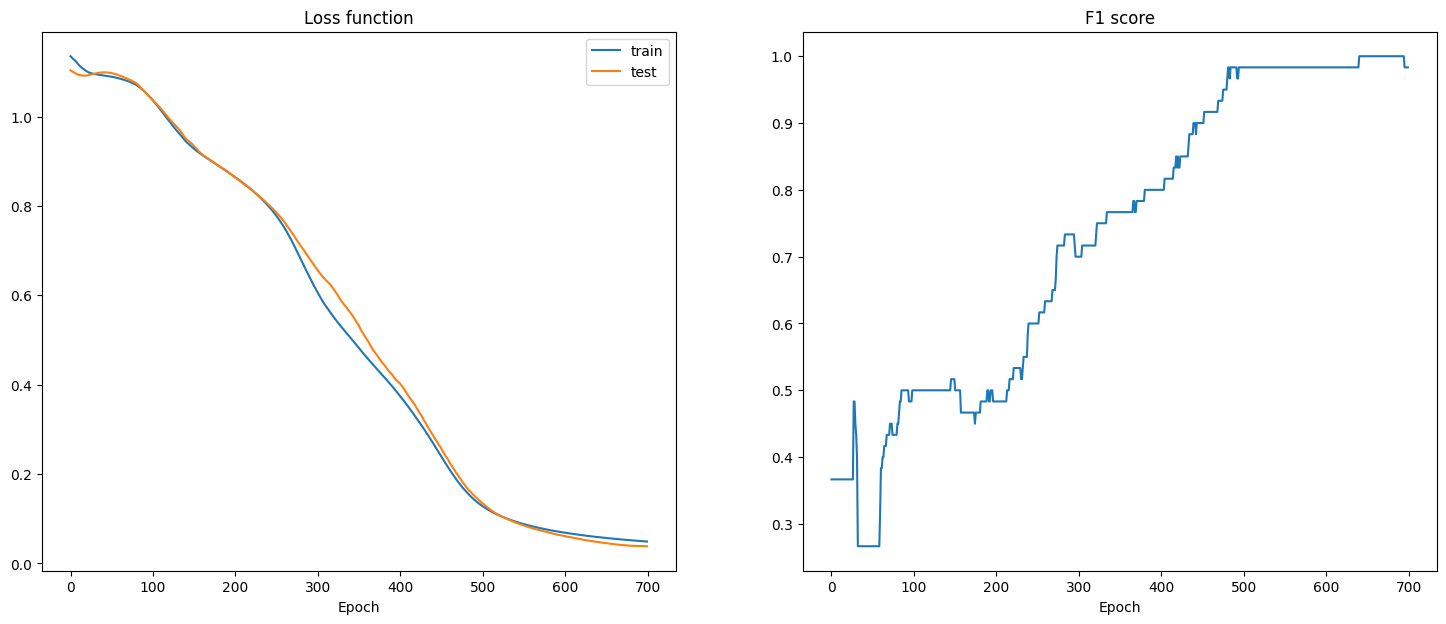

In [100]:
plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
plt.title('Loss function')
plt.plot(loss_train_array, label='train')
plt.plot(loss_test_array, label='test')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('F1 score')
plt.plot(f1_array)
plt.xlabel('Epoch')

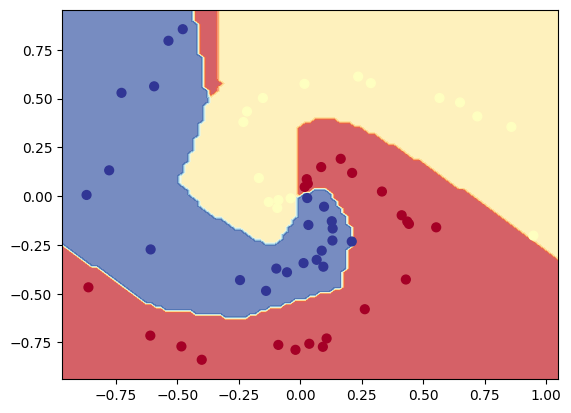

In [101]:
plot_decision_boundary(model=model_v2,
                       X=X_test,
                       y=y_test)

In [107]:
model_v2.eval()
with torch.inference_mode():
    predicted_logits = model_v2(X_test)
    predicted_labels = predicted_logits.argmax(dim=1)
print(f'Accuracy is {(acc(predicted_labels, y_test).item()*100):.3f}%')

Accuracy is 98.333%
